# Modeler Starter Kit
This notebook will walk you through the entire challenge lifecycle, from fetching the training data, to training a model, to submitting your model for evaluation.

There are two phases of outputs required to submit a model for evaluation:
- Phase 1: Commit to a model with an onnx file and input_data.
- Phase 2: Generate a file that contains test set predictions and the feature values required to generate those predictions. 

After both phases, you will have a submission directory with three files
1. model_1.onnx
2. model_1_cal_data.json
3. submission.parquet


## Fetch Training Data
The following code will allow you to download the training dataset for this competition using the Spectral CLI.

The training dataset is a tabular file, where each row represents a borrow event at the specified timestamp. 

Each row contains a timestamp and Ethereum block number, the wallet address that initiated the borrow transaction, a list of features including borrower and market activity, and a binary target variable indicating if the borrower was liquidated within 30 days of the borrow event.

[See our data dictionary for a full list of features, their types, and descriptions.](https://docs.spectral.finance/modeler-handbook/2.-model-training/step-3-fetch-training-dataset)

During testing and consumption, you will be given all of these values aside from the target variable. Your model will be evaluated on the ability to predict the target variable for each sample in the test set.



In [1]:
# Download Training Data
!spectral-cli fetch-training-data 0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929

100%|███████████████████████████████████████| 112M/112M [00:02<00:00, 51.2MiB/s]
Training dataset successfully downloaded!


This file should be around 112MB, if you have a file only a few kb in size try using a VPN as IPFS is often blocked by some internet service providers.

Examine a subset of the dataset

In [2]:
import duckdb
duckdb.query((f"""
select * from '{'0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929_training_data.parquet'}' limit 10
""")).df()

,borrow_block_number,borrow_timestamp,wallet_address,target,unique_borrow_protocol_count,unique_lending_protocol_count,total_collateral_eth,misc_available_borrows_eth,risk_factor,risk_factor_above_threshold_daily_count,...,total_balance_eth,withdraw_amount_sum_eth,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,withdraw_deposit_diff_If_positive_eth
0,7711117,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,0,1,44.479139,31.575270,0.000001,0.0,...,58.317987,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
1,7711123,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.418863,0.004953,0.0,...,58.317987,0.0,0.157110,0.157110,1,0.0,0.0,0,0.157110,0.0
2,7711126,1.557197e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.479139,31.035236,0.017103,0.0,...,58.317987,0.0,0.543275,0.271637,2,0.0,0.0,0,0.543275,0.0
3,7711672,1.557205e+09,0xa7ff0d561cd15ed525e31bbe0af3fe34ac2059f6,0,0,1,0.000767,0.000460,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
4,7712572,1.557217e+09,0xbd9ed130a53cfafcf81502e4d35329a6c4d53410,0,0,1,0.010000,0.007500,0.000001,0.0,...,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0,0.000000,0.0
5,7715069,1.557250e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.488424,30.059852,0.048606,0.0,...,58.317987,0.0,1.543275,0.514425,3,0.0,0.0,0,1.543275,0.0
6,7715078,1.557251e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,44.430545,29.912079,0.052241,0.0,...,58.317987,0.0,1.543275,0.514425,4,0.0,0.0,0,1.543275,0.0
7,7715985,1.557263e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,51.316928,28.781848,0.088052,0.0,...,58.317987,0.0,2.749083,0.687271,5,0.0,0.0,0,2.749083,0.0
8,7716888,1.557276e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,58.791139,38.667542,0.081422,0.0,...,3.127926,0.0,3.320086,0.664017,6,0.0,0.0,0,3.320086,0.0
9,7717003,1.557277e+09,0x502cb8985b2c92a8d4bf309cdaa89de9be442708,1,1,1,60.268602,33.574491,0.221625,0.0,...,3.127926,0.0,9.247470,1.541245,7,0.0,0.0,0,9.247470,0.0


You may choose to use any subset of the data above to train your model. We guarantee the availability of this data during the challenge lifespan.
You may also supplement this set with external data, however, you will be responsible for hosting and serving this data during testing and consumption.

## Exploratory Data Analysis

You may use any tools you wish to explore the data and generate features. 

As an example, we examine the max_risk_factor feature, look for potential outliers, consider dropping those samples, and look for correlated features. 

A borrower's risk_factor is defined as 1 / their minimum health factor across DeFi protocols.

For a background on health factors, see Aave's documentation [here](https://docs.aave.com/risk/v/aave-v2/asset-risk/risk-parameters#health-factor).

In [3]:
training_dataframe = duckdb.query((f"""
select * from '{'0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929_training_data.parquet'}'
""")).df()
training_dataframe['max_risk_factor'].describe()

count    4.406890e+05
mean     2.885612e+08
std      3.237624e+10
min      0.000000e+00
25%      3.829586e-01
50%      7.578586e-01
75%      9.122225e-01
max      3.633082e+12
Name: max_risk_factor, dtype: float64

The max value listed above is far greater than the majority of samples, and may be an outlier. A risk factor over one is uncommon, so a value this large could be due to a highly irregular onchain action, an error in data fetching, or an error dataset construction. 



We should examine samples with high values of this feature.

In [4]:
duckdb.query((f"""
select count(distinct(wallet_address)) as unusually_high_risk_factor_address 
from '{'0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929_training_data.parquet'}'
where max_risk_factor > 100
""")).df()

,unusually_high_risk_factor_address
0,61


There are 61 addresses with this unusually high value, let's remove all samples with a risk factor over 100 from training. 

In [5]:
training_dataframe = duckdb.query((f"""
select * from '{'0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929_training_data.parquet'}'
where max_risk_factor < 100
""")).df()
training_dataframe['max_risk_factor'].describe()

count    438906.000000
mean          0.789639
std           2.281565
min           0.000000
25%           0.378455
50%           0.756124
75%           0.909860
max          86.364163
Name: max_risk_factor, dtype: float64

A risk factor of 86 is still highly unusual, but we will leave it in for now as this is only an example.

It's always helpful to visualize data when getting acquainted, so let's examine a few features together. We'll look at the correlation between the withdraw_deposit_diff_If_positive_eth, withdraw_amount_sum_eth, and deposit_amount_sum_eth features.


These DeFi features represent the total amount of eth withdrawn, eth deposited, and the difference between the two.

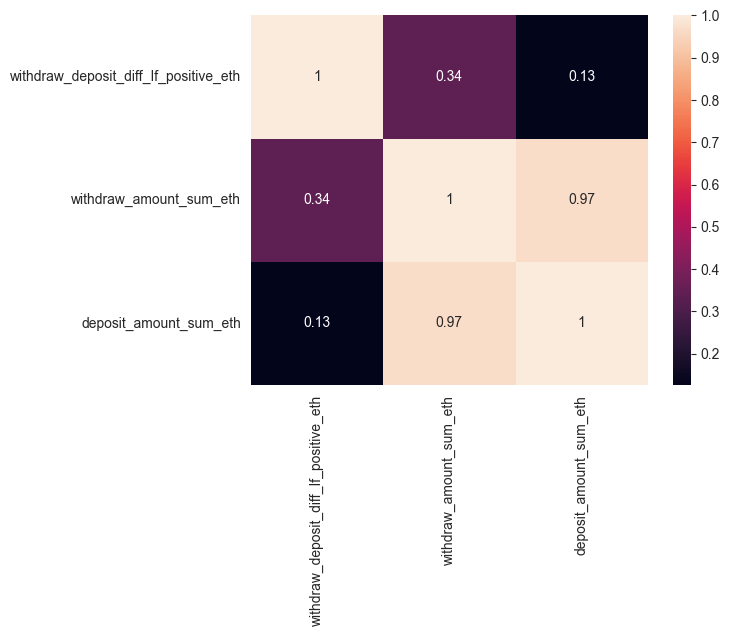

In [6]:
import matplotlib.pyplot as mp 
import seaborn as sb 
dataplot = sb.heatmap(training_dataframe[['withdraw_deposit_diff_If_positive_eth',
                                          'withdraw_amount_sum_eth',
                                          'deposit_amount_sum_eth' ]].corr(), annot=True) 
mp.show() 

These features represent actions on opposite ends of the lending lifecycle, so we could reasonably expect there to be some correlation for many samples.

withdraw_amount_sum_eth and deposit_amount_sum_eth are highly correlated, so we'll move to drop withdraw_amount_sum_eth from our training set. In practice, it would be beneficial to examine the correlation between other features and understand why some of these may be correlated or not.  

For this example we'll conclude our analysis, and move to modelling. During the challenge you should spend time exploring the data and generating features. There is no shortage of exciting onchain activity that could be used to generate features, and we encourage you to be creative. 


Features derived from activity on other lending protocols, other chains, non-fungible token value, and decentralized exchange positions have all proven to be relevant in our previous work. Want to discuss with other modelers and our team? Join our [Discord](https://discord.gg/w7mKT2KBKh)

## Modeling

**The only supported models for this challenge are:**
- Neural networks using PyTorch (other than recurrent neural networks, e.g., LSTM) 
- and logistic regression using PyTorch

**If you use a model that does not meet the criteria above, you will be unable to participate in this challenge**

### Train a neural net using the provided dataset

This model is strictly for example purposes and is not intended to be a model that places high in this challenge. 
You should not make assumptions based on this model that this is how the problem should be approached. 


In particular, you should not assume:
- anything about the relevancy of features and samples dropped above
- that ReLU is the ideal activation function (or any other architecture specifics defined herein)

In [7]:
# Start by loading our training data
import duckdb
training_dataframe = duckdb.query((f"""
select * from '{'0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

In [8]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import json
from tqdm.auto import tqdm
from timeit import default_timer as timer 
import random
import os

# Spectral Helpers (see helpers folder for more details on any of these
from helpers.modeling import (TestData, TrainData, StratifiedBatchSampler,
                              print_train_time, auc_fn, auroc_fn, auc_pr_fn,
                              brier_fn, ks_fn, recall_fn, prob_diff_fn, f1_score_fn,
                              train_step, test_step, eval_model, plot_loss_curves,
                              ValidationLossEarlyStopping)

# for reproducible results
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.determenistic=True

random.seed(random_seed)
def seed_worker(worker_id):
    worker_seed = random_seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(random_seed)

#specifically required for reproducibility with CuBLABS and CUDA
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
os.environ["PYTHONHASHSEED"] = str(random_seed)

We'll use the same training dataset we defined above, and split it into training and testing sets.

***TODO: Fix when Data api is up***

In [9]:
# We're going to hold out 10K samples for "realtime" testing while data api is down
example_testing_samples = training_dataframe[-10_000:].drop_duplicates(subset=['wallet_address'], keep='first')

training_dataframe = training_dataframe[:-10_000]


In [10]:
training_cols = list(training_dataframe.columns.drop(
    ['borrow_timestamp', 'wallet_address', 'borrow_block_number', 'target']))



X_train, X_test, y_train, y_test = train_test_split(training_dataframe[training_cols].to_numpy(),
                                                    training_dataframe['target'].to_numpy(),
                                                    test_size=0.2,
                                                    random_state=random_seed)



# Note that if you scale your training data, you must scale the test data in the same way
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [11]:
train_data = TrainData(torch.from_numpy(X_train_scaled).type(torch.float),
                       torch.from_numpy(y_train).type(torch.float))

test_data = TestData(torch.from_numpy(X_test_scaled).type(torch.float),
                     torch.from_numpy(y_test).type(torch.float))

In [12]:
NUM_WORKERS = 0 # use all available CPU cores with os.cpu_count(), if possible
BATCH_SIZE = int(X_train.shape[0]/100) # ~1% of the training data
# initialize DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_sampler=StratifiedBatchSampler(torch.tensor(y_train), batch_size=BATCH_SIZE), 
                              worker_init_fn=seed_worker, 
                              generator=g,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             worker_init_fn=seed_worker,
                             generator=g,
                             num_workers=NUM_WORKERS)

print(f'Dataloaders: {train_dataloader, test_dataloader}') 
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')
print(f'Using number of workers: {NUM_WORKERS}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2a109e850>, <torch.utils.data.dataloader.DataLoader object at 0x2a1027090>)
Length of train dataloader: 101 batches of 3431
Length of test dataloader: 26 batches of 3431
Using number of workers: 0


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([3398, 73]), torch.Size([3398]))

In [14]:
# Check out what's inside the testing dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([3431, 73]), torch.Size([3431]))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Define an Example Model

In [16]:
class PredictLiquidationsV1(nn.Module):
    """
    The final layer should be a sigmoid, to get the probability of liquidation. 
    """
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.4),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# instantiate the model
model_1 = PredictLiquidationsV1(input_features=X_train.shape[1],
                                output_features=1,
                                hidden_units=82).to(device)
model_1

PredictLiquidationsV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=73, out_features=82, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=82, out_features=82, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=82, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [17]:
early_stopper = ValidationLossEarlyStopping(patience=1, min_delta=0.0)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model_1.parameters(),
                       lr=0.001,
                       weight_decay=0.01)

In [18]:
# Measure time
train_time_start = timer()

epochs = 30

# Create empty loss lists to track values
model_1_train_loss_values = []
model_1_test_loss_values = []
model_1_epoch_count = []

for epoch in tqdm(range(epochs)):
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n---------")
    train_metrics = train_step(data_loader=train_dataloader, 
                               model=model_1, 
                               epochs=epoch,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               auc_fn=auc_fn,
                               recall_fn=recall_fn,
                               f1_score_fn=f1_score_fn,
                               auroc_fn=auroc_fn,
                               brier_fn=brier_fn,
                               auc_pr_fn=auc_pr_fn,
                               ks_fn=ks_fn,
                               prob_diff_fn=prob_diff_fn
    )
    test_metrics = test_step(data_loader=test_dataloader,
                             model=model_1,
                             epochs=epoch,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn
    )
    model_1_epoch_count.append(epoch)
    model_1_train_loss_values.append(train_metrics['loss'])
    model_1_test_loss_values.append(test_metrics['loss'])
    
    if early_stopper.early_stop_check(test_metrics['loss']):
        print(f"Stopped early at epoch: {epoch}\n---------")
        
        print(f"Training metrics:\nLoss: {train_metrics['loss']:.5f} "
              f"| Recall: {train_metrics['recall']:.2f}% | F1-Score: {train_metrics['f1']:.2f}% "
              f"| AUROC: {train_metrics['auroc']:.2f}% | Brier Score: {train_metrics['brier']:.2f}% "
              f"| AUC PR: {train_metrics['aucpr']:.2f}% | KS-Statistic: {train_metrics['ks']:.2f}% "
              f"| Pred Prob Diff: {train_metrics['prob_diff']:.2f}%")
        
        print(f"Testing metrics:\nLoss: {test_metrics['loss']:.5f} "
              f"| Recall: {test_metrics['recall']:.2f}% | F1-Score: {test_metrics['f1']:.2f}% "
              f"| AUROC: {test_metrics['auroc']:.2f}% | Brier Score: {test_metrics['brier']:.2f}% "
              f"| AUC PR: {test_metrics['aucpr']:.2f}% | KS-Statistic: {test_metrics['ks']:.2f}% "
              f"| Pred Prob Diff: {test_metrics['prob_diff']:.2f}%")
        break

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)


# If you see a red progress bar below that's due to the early stopping criteria being met
# Not a cause for concern in this example

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Training metrics:
Loss: 0.57473 | Recall: 35.28% | F1-Score: 44.35% | AUROC: 73.21% | Brier Score: 19.51% | AUC PR: 67.93% | KS-Statistic: 37.97% | Pred Prob Diff: 16.60%
Testing metrics:
Loss: 0.49889 | Recall: 57.36% | F1-Score: 66.53% | AUROC: 80.80% | Brier Score: 16.29% | AUC PR: 77.95% | KS-Statistic: 49.62% | Pred Prob Diff: 32.96%
Epoch: 5
---------
Training metrics:
Loss: 0.46803 | Recall: 58.16% | F1-Score: 67.52% | AUROC: 83.27% | Brier Score: 15.18% | AUC PR: 80.22% | KS-Statistic: 51.65% | Pred Prob Diff: 39.83%
Testing metrics:
Loss: 0.46587 | Recall: 60.73% | F1-Score: 69.02% | AUROC: 83.27% | Brier Score: 15.11% | AUC PR: 80.79% | KS-Statistic: 52.42% | Pred Prob Diff: 42.43%
Epoch: 10
---------
Training metrics:
Loss: 0.46555 | Recall: 58.38% | F1-Score: 67.72% | AUROC: 83.53% | Brier Score: 15.09% | AUC PR: 80.45% | KS-Statistic: 52.05% | Pred Prob Diff: 40.19%
Testing metrics:
Loss: 0.46319 | Recall: 60.85% | F1-Score: 69.24% | AUROC: 83.86% | Brie

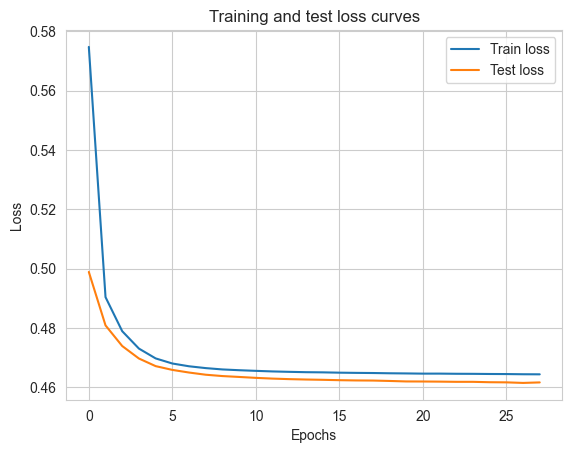

In [19]:
plot_loss_curves(model_1_epoch_count, model_1_train_loss_values, model_1_test_loss_values)

In [20]:
# Calculate model 1 results
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn,
                             device=device)
model_1_results.update({'model_name': model_1.__class__.__name__})

model_1_results

{'model_name': 'PredictLiquidationsV1',
 'model_loss': 0.4616559147834778,
 'model_rec': 59.96145512507512,
 'model_f1': 69.0419549208421,
 'model_auroc': 83.9932608971229,
 'model_brier': 14.937980330376018,
 'model_aucpr': 81.27505229069637,
 'model_ks': 53.32760244111866,
 'model_prob_diff': 41.21921108319209}

# Submission Phase 1

### Generate onnx file and input data json

In [21]:
# You will commit files in the submission directory
# If one does not exist create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

In [22]:
model_1.eval()
torch.onnx.export(model_1,
                  torch.randn((1, X_train.shape[1]), requires_grad=True).to(device),
                  'submissions/model_1.onnx',
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}})

Export an observation from the test dataset that will be used to calibrate the ezkl settings file.

This list of feature values can be from the test data (as shown here) or a completely different sample that will be representative of the data seen in production. 

In [23]:
x = next(iter(test_features_batch)).numpy().tolist()
data = dict(input_data=[x])
json.dump(data, open('submissions/model_1_cal_data.json', 'w'))

### Commit to a Model

**If this is your first time committing a model, you will need to configure the Spectral CLI.**

Begin with Step 5 in our [Gitbook](https://docs.spectral.finance/modeler-handbook/3.-submission/step-5-configure-spectral-cli) and return here for Step 6's "Submit model commitment (never the model itself!)"

In [24]:
!spectral-cli commit submissions/model_1.onnx submissions/model_1_cal_data.json 0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929

Settings successfully generated
[00:00:08] ########################################      63/63      Calibration Done.Settings successfully calibratediplier: 10[1A
Model successfully compiled
[00:00:00] ------ - 👾  SRS validated                                           spawning module 2----- - ✨  Validating SRS (this may take a while) ...              
spawning module 2
EZKL Setup was successful

Commitment successfully uploaded to IPFS: QmejkijLEhHHes6Q5ZJtRcCJcxcUraGgJHXw4ndE1kT81n
Submitting model with CID: QmejkijLEhHHes6Q5ZJtRcCJcxcUraGgJHXw4ndE1kT81n to challenge: 0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929. This may take a moment.
Your submission has been recorded successfully!
You can check status of that transaction under: https://goerli.arbiscan.io/tx/0x03a71aac1ed74056fa7ab7035c5b8c43cd1775e9076e105405996285ed5b663e


# Submission Phase 2
### Generate Predictions File

Each modeler will receive their unique test set and will be responsible for generating predictions for each sample in the test set.

In [25]:
# Generate predictions for each address in the test st
wallet_address = example_testing_samples['wallet_address']
example_testing_samples_scaled = sc.transform(example_testing_samples[training_cols])
model_1.eval()
with torch.inference_mode():
    pol = model_1(torch.tensor(example_testing_samples_scaled).float().to(device)).squeeze().detach().cpu().numpy()
submission_dataframe = pd.DataFrame(example_testing_samples_scaled, index=example_testing_samples.index, columns=example_testing_samples[training_cols].columns)
submission_dataframe['wallet_address'] = wallet_address
submission_dataframe['probability_of_liquidation'] = pol
submission_dataframe.head()

,unique_borrow_protocol_count,unique_lending_protocol_count,total_collateral_eth,misc_available_borrows_eth,risk_factor,risk_factor_above_threshold_daily_count,max_risk_factor,misc_avg_total_collateral_eth,total_available_borrows_eth,avg_weighted_risk_factor,...,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,withdraw_deposit_diff_If_positive_eth,wallet_address,probability_of_liquidation
428906,0.052589,-0.504534,-0.092871,-0.080028,-1.228554,-0.193038,-0.344708,-0.104331,-0.088311,-0.076748,...,8.917059,0.455103,8.699692,9.807047,0.540140,10.541494,-0.110924,-0.012348,0xfac983fce7ef3cee8ffb2ceb967e1b2362aada00,0.007661
428907,0.052589,-0.504534,-0.092557,-0.079906,1.463594,0.079204,0.046498,-0.102827,-0.086565,-0.075928,...,-0.142860,-0.138914,-0.191098,-0.135346,-0.144267,-0.220155,-0.110924,-0.012348,0xfa273296a238ea726d9af7eb835c9c586784ea2d,0.628957
428908,0.052589,-0.504534,0.476919,0.608761,0.630778,-0.141182,-0.344708,1.735181,1.861922,1.099189,...,-0.053739,-0.095853,0.876454,0.055585,-0.065406,1.383902,-0.110924,0.141910,0xea80829c827f1633a46e7ea6026ed693ca54eebd,0.068829
428909,0.052589,-0.504534,-0.092548,-0.079648,0.674411,-0.193038,-0.024400,-0.103870,-0.087740,-0.076488,...,-0.142942,-0.137896,-0.251318,-0.135919,-0.152411,-0.259599,-0.109536,-0.012348,0x23a37a07845c887dc65d76052d8105d5f67402f7,0.222577
428910,0.052589,-0.504534,-0.092679,-0.079426,-1.228554,8.252944,0.078645,-0.075045,-0.076324,-0.036980,...,0.142023,-0.102421,4.111957,0.157255,-0.032505,1.567974,-0.011983,-0.012348,0xf9c241b6ad269ac8e8cdb24a540f6cce0ec9e0dd,0.935347


As a modeler, you will choose to set the target variable to 1 if the probability of liquidation is greater than some threshold.

In this example, we'll take the threshold to be 0.6, but you may find a different value is more appropriate (perhaps the one returned by the `auc_fn` function in `helpers.modeling`). 

This threshold should not be taken as a recommendation for the challenge and is only used for this example.

In [26]:
submission_dataframe['target'] = (
    submission_dataframe['probability_of_liquidation'].apply(lambda x: 1 if x > .6 else 0))

Now, we need to format our dataframe correctly to meet the requirements for submission. Each row in the dataframe will consist of a wallet address, predicted probability, predicted target label, and the input features (without any feature names) used to generate the prediction.

The input features (just the values) will be needed to (later) prove that the predictions are generated from the committed model from Phase 1.

**The final submission file must follow the naming conventions below.** 

In [27]:
non_feature_cols = ['wallet_address', 'probability_of_liquidation', 'target']
for index, col in enumerate(submission_dataframe.columns):
    if col not in non_feature_cols:
        submission_dataframe.rename(columns={col: f'feature_{index+1}'}, inplace=True)

In [28]:
# We're also ordering the columns for readability, this step is optional
cols_order_list = non_feature_cols + [col for col in submission_dataframe.columns if col not in non_feature_cols]
submission_dataframe = submission_dataframe[cols_order_list]
submission_dataframe.to_parquet('submissions/submission.parquet')
submission_dataframe.head()

,wallet_address,probability_of_liquidation,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73
428906,0xfac983fce7ef3cee8ffb2ceb967e1b2362aada00,0.007661,0,0.052589,-0.504534,-0.092871,-0.080028,-1.228554,-0.193038,-0.344708,...,-0.014991,-0.055975,8.917059,0.455103,8.699692,9.807047,0.540140,10.541494,-0.110924,-0.012348
428907,0xfa273296a238ea726d9af7eb835c9c586784ea2d,0.628957,1,0.052589,-0.504534,-0.092557,-0.079906,1.463594,0.079204,0.046498,...,-0.014991,-0.058129,-0.142860,-0.138914,-0.191098,-0.135346,-0.144267,-0.220155,-0.110924,-0.012348
428908,0xea80829c827f1633a46e7ea6026ed693ca54eebd,0.068829,0,0.052589,-0.504534,0.476919,0.608761,0.630778,-0.141182,-0.344708,...,-0.014755,-0.058032,-0.053739,-0.095853,0.876454,0.055585,-0.065406,1.383902,-0.110924,0.141910
428909,0x23a37a07845c887dc65d76052d8105d5f67402f7,0.222577,0,0.052589,-0.504534,-0.092548,-0.079648,0.674411,-0.193038,-0.024400,...,-0.014967,-0.058050,-0.142942,-0.137896,-0.251318,-0.135919,-0.152411,-0.259599,-0.109536,-0.012348
428910,0xf9c241b6ad269ac8e8cdb24a540f6cce0ec9e0dd,0.935347,1,0.052589,-0.504534,-0.092679,-0.079426,-1.228554,8.252944,0.078645,...,-0.014972,-0.057715,0.142023,-0.102421,4.111957,0.157255,-0.032505,1.567974,-0.011983,-0.012348


### Submit Predictions File
Once a predictions file has been generated, and you are satisfied with the results, you may submit your predictions for evaluation.

Prior to running this step ensure the Spectral CLI wallet is funded with gas for this transaction.

In [30]:
!spectral-cli submit-inferences 0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929 submissions/submission.parquet

Submitting response with CID: QmP2Zw3wViamcvsKRx8fxjV4LjKrAAahjgnZLXDCWpVKfj to challenge: 0x0163655101Dd34f5a7D8cC9c52Fa60AfcED1c929. This may take a moment.
Submitting your inferences failed
You can check status of that transaction under: https://goerli.arbiscan.io/tx/0x1889c9d08b2d70e5370ae434ec55db05208b69f7ed6e1eb549cd0c65678f1574


### Ensure that both the commitment and Submission transactions are successful and note the transaction hash for reference later. 